## Assessed Task 2: Prostate Cancer Classification (Specification)

Prostate cancer is the most commonly diagnosed cancer in Australia; it is estimated that more than 24,200 males were diagnosed in Australia with this form of cancer in 2022. If diagnosed early, prostate cancer has one of the highest survival rates. Growths in the prostate can be benign (not cancer) or malignant (cancer). 

The task in this assignment is to investigate how well three different machine learning algorithms can predict whether the result of a biopsy is benign or malignant using a number of independent variables. 

The dataset that we are going to use is a modified version of a small prostate cancer dataset that contains missing values. This data consists of 10 variable about prostate cancer tumors taken from 100 biopsies. These variables are:

* id
* diagnosis_result
* radius
* texture
* perimeter
* area
* smoothness
* compactness
* symmetry
* fractal_dimension

The dependent variable 'diagnosis_result' is a categorial one where 'B' stands for benign and 'M' for malignant; all other variables are numeric, and 'id' is not required for making predications.

This assessed task is worth 10 marks and consists of 14 tasks. For each task, marks will be awarded for the correct output and for the quality of code (the code does what it should do; follows a consistent style, and is easy to understand).

In [ ]:
import numpy as np   
import pandas as pd  

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier  
import xgboost

from sklearn.model_selection import train_test_split  
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import preprocessing

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score


import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### Loading, Pre-processing and Inspecting the Data

***Step 1:*** Load the csv dataset (prostate-cancer-mod.csv) into a pandas dataframe and display the first five rows.

In [ ]:
df = pd.read_csv("prostate-cancer-mod.csv", index_col = False)
df.head(5)

,id,diagnosis_result,radius,texture,perimeter,area,smoothness,compactness,symmetry,fractal_dimension
0,1,M,23,12,151.0,954.0,0.143,0.278,0.242,0.079
1,2,B,9,13,133.0,1326.0,0.143,0.079,0.181,0.057
2,3,M,21,27,130.0,NaN,0.125,0.160,0.207,0.060
3,4,M,14,16,78.0,386.0,0.070,NaN,0.260,0.097
4,5,M,9,19,135.0,1297.0,0.141,0.133,0.181,0.059


***Task 2:*** Drop the 'id' column since the values in this column will not contribute anything to the ML model, and then display the first five rows of the dataframe. [0.25 mark]

In [ ]:
df = df.drop('id', axis = 1)
df.head(5)

,diagnosis_result,radius,texture,perimeter,area,smoothness,compactness,symmetry,fractal_dimension
0,M,23,12,151.0,954.0,0.143,0.278,0.242,0.079
1,B,9,13,133.0,1326.0,0.143,0.079,0.181,0.057
2,M,21,27,130.0,NaN,0.125,0.160,0.207,0.060
3,M,14,16,78.0,386.0,0.070,NaN,0.260,0.097
4,M,9,19,135.0,1297.0,0.141,0.133,0.181,0.059


***Step 3***: Generate a countplot using seaborn and display the diagnosis results 


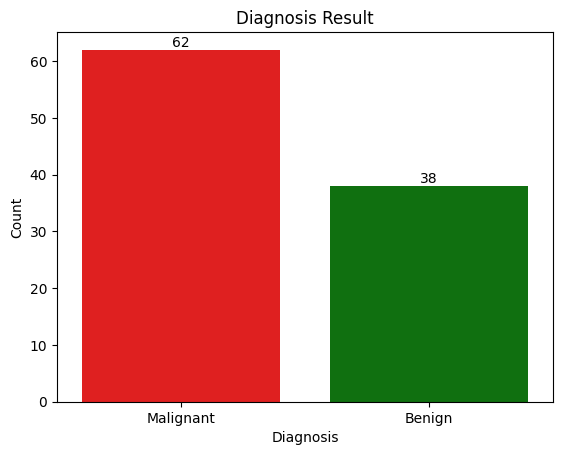

In [ ]:
df["diagnosis_result"] = df["diagnosis_result"].map({'M': 'Malignant', 'B': 'Benign'})
ax = sns.countplot(x=df["diagnosis_result"],palette=['r', 'g'])
ax.set(xlabel='Diagnosis', ylabel='Count')

abs_values = df['diagnosis_result'].value_counts(ascending=False).values
ax.bar_label(container=ax.containers[0], labels=abs_values)

plt.title('Diagnosis Result')
plt.show()

***Step 4***: Replace the categorical values in the 'diagnosis_results' column by 1 for 'M' (malignant) and 0 for 'B' (benign) and display the first five rows . 

In [ ]:
df["diagnosis_result"] = df["diagnosis_result"].map({'Malignant': 1, 'Benign': 0})
df.head(5)

,diagnosis_result,radius,texture,perimeter,area,smoothness,compactness,symmetry,fractal_dimension
0,1,23,12,151.0,954.0,0.143,0.278,0.242,0.079
1,0,9,13,133.0,1326.0,0.143,0.079,0.181,0.057
2,1,21,27,130.0,NaN,0.125,0.160,0.207,0.060
3,1,14,16,78.0,386.0,0.070,NaN,0.260,0.097
4,1,9,19,135.0,1297.0,0.141,0.133,0.181,0.059


***Step 5***: Check whether or not the dataframe contains missing values. 

In [ ]:
df.isnull().sum()

diagnosis_result     0
radius               0
texture              0
perimeter            2
area                 4
smoothness           2
compactness          2
symmetry             3
fractal_dimension    0
dtype: int64

***Step 6***: Replace missing values in each column of the dataframe by the median.

In [ ]:
df.fillna(df.median(), inplace = True)
df.isnull().sum()

diagnosis_result     0
radius               0
texture              0
perimeter            0
area                 0
smoothness           0
compactness          0
symmetry             0
fractal_dimension    0
dtype: int64

***Step 7***: Investigate how the variables in the data are correlated. For this purpose, generate a heatmap using seaborn. 

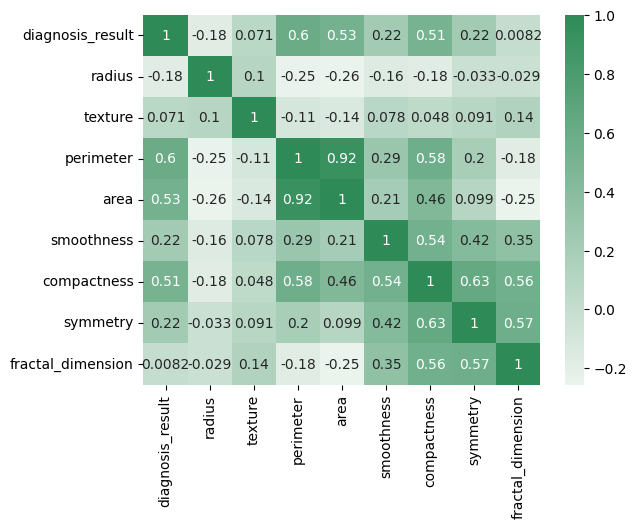

In [ ]:
cmap = sns.light_palette("seagreen", as_cmap=True)
sns.heatmap(df.corr(), annot=True, cmap = cmap)

plt.show()

***Step 8***: Display a histogram .

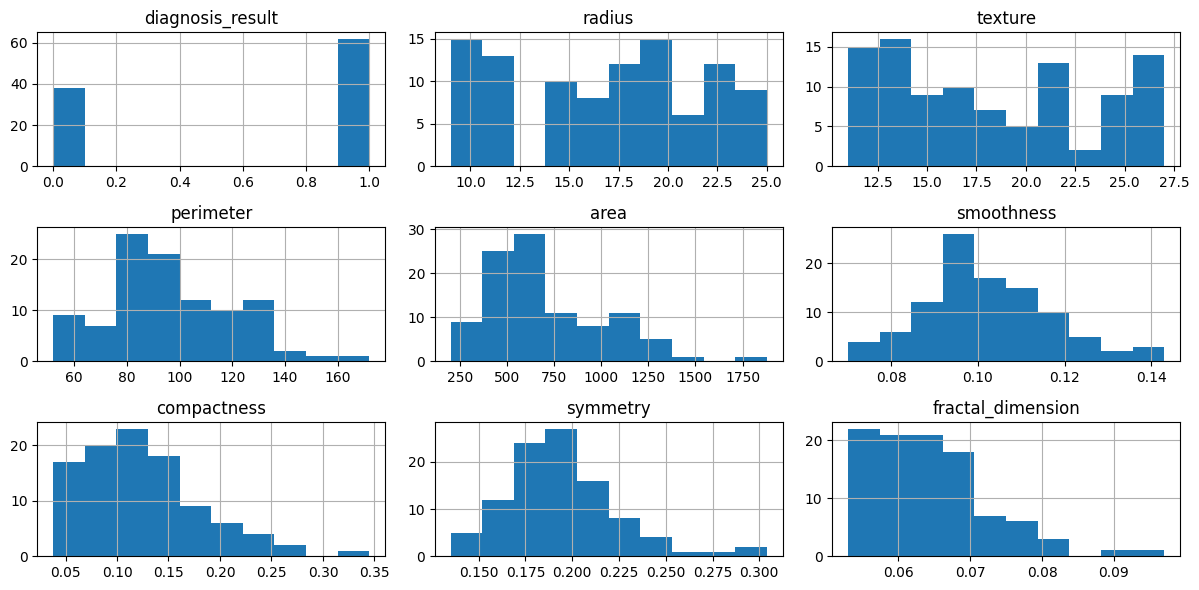

In [ ]:
df.hist(bins=10, figsize=(12, 6))
plt.tight_layout() 
plt.show()

## Train/Test Split

***Step 9***: Separate the independent and dependent variables of the dataframe, generate a training/test split with a test size of 30%. 

In [ ]:
X = df[df.columns.difference(['diagnosis_result'])]
y = df['diagnosis_result']

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.3, random_state = 42)
print((X_train.shape,X_test.shape,y_train.shape,y_test.shape))


((70, 8), (30, 8), (70,), (30,))


## Defining and Fitting the Classifiers

We use the following three classifiers: a decision tree classifier, a random forest classifier, and an XGB classifier. For each classifier, we specify a simple pipeline with the settings as show below. Since our features have different scales, we standardise them using a standard scaler in a proprocessing step.


In [ ]:
print('Defining the classifiers ...')

dt_clf = Pipeline(steps=[('preprocessor', preprocessing.MinMaxScaler()), 
                         ('model', DecisionTreeClassifier(random_state = 42))])

rf_clf = Pipeline(steps=[('preprocessor', preprocessing.MinMaxScaler()),
                         ('model', RandomForestClassifier(n_estimators = 1000, random_state = 42))])

xgb_clf = Pipeline(steps=[('preprocessor', preprocessing.MinMaxScaler()), 
                          ('model', xgboost.XGBClassifier(n_estimators = 1000, 
                          learning_rate = 0.05, eval_metric =[ 'logloss', 'auc', 'error'], 
                          use_label_encoder = False,
                          random_state = 42))])

print('Done!')

Defining the classifiers ...
Done!


***Step 10***: Fit the three classifiers to the training data.

In [ ]:
print('Configuring classifers to fit train data ...')
dt_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
xgb_clf.fit(X_train, y_train)
print('Done!')

Configuring classifers to fit train data ...
Done!


## Making Predictions

***Step 11***: Use the test features to make predictions for each model and display the results. 

In [ ]:
dt_clf_predict = dt_clf.predict(X_test)
rf_clf_predict = rf_clf.predict(X_test)
xgb_clf_predict = xgb_clf.predict(X_test)

In [ ]:
print(dt_clf_predict)

[1 1 1 1 0 1 1 0 1 0 1 0 1 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1]


In [ ]:
print(rf_clf_predict)

[1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 1 0 0 0 1]


In [ ]:
print(xgb_clf_predict)

[1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 1 0 0 0 1]


## Evaluating the Classifiers

***Step 12***: Calculate and display the classification accuracy in percentage for each model.

In [ ]:
dt_clf_acc = dt_clf.score(X_test, y_test)
rf_clf_acc = rf_clf.score(X_test, y_test)
xgb_clf_acc = xgb_clf.score(X_test, y_test)

print('Accuracy: Decision tree = {:.2f}%'.format(dt_clf_acc*100))
print('Accuracy: Random Forest = {:.2f}%'.format(rf_clf_acc*100))
print('Accuracy: XGBoost = {:.2f}%'.format(xgb_clf_acc*100))

Accuracy: Decision tree = 60.00%
Accuracy: Random Forest = 76.67%
Accuracy: XGBoost = 80.00%


## Visualising and Summarising the Performance¶

***Step 13***: Display the model performance for all three classifiers by comparing the predicated classes with the expected classes. Use a seaborn heatmap to display these confusion matrices and then add a calssification report.

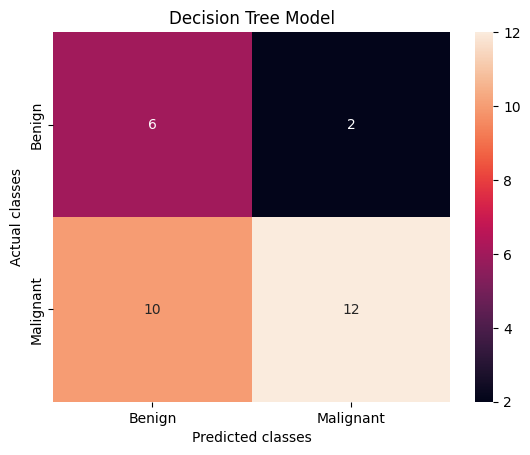

Classification Report
              precision    recall  f1-score   support

           0       0.38      0.75      0.50         8
           1       0.86      0.55      0.67        22

    accuracy                           0.60        30
   macro avg       0.62      0.65      0.58        30
weighted avg       0.73      0.60      0.62        30



In [ ]:
dt_clf_conf = pd.DataFrame(
    confusion_matrix(y_test, dt_clf_predict), 
    index=['Benign', 'Malignant'], 
    columns=['Benign', 'Malignant']
)

ax = sns.heatmap(dt_clf_conf, annot=True) # font size
ax.set(xlabel='Predicted classes', ylabel='Actual classes')

plt.title('Decision Tree Model')
plt.show()
print("Classification Report")
print(classification_report(y_test, dt_clf_predict))

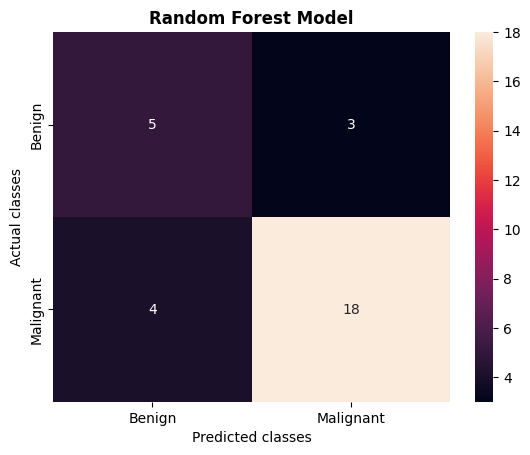

Classification Report
              precision    recall  f1-score   support

           0       0.56      0.62      0.59         8
           1       0.86      0.82      0.84        22

    accuracy                           0.77        30
   macro avg       0.71      0.72      0.71        30
weighted avg       0.78      0.77      0.77        30



In [ ]:
rf_clf_conf = pd.DataFrame(
    confusion_matrix(y_test, rf_clf_predict), 
    index=['Benign', 'Malignant'], 
    columns=['Benign', 'Malignant']
)

ax = sns.heatmap(rf_clf_conf, annot=True) # font size
ax.set(xlabel='Predicted classes', ylabel='Actual classes')

plt.title('Random Forest Model', weight="bold")
plt.show()
print("Classification Report")
print(classification_report(y_test, rf_clf_predict))

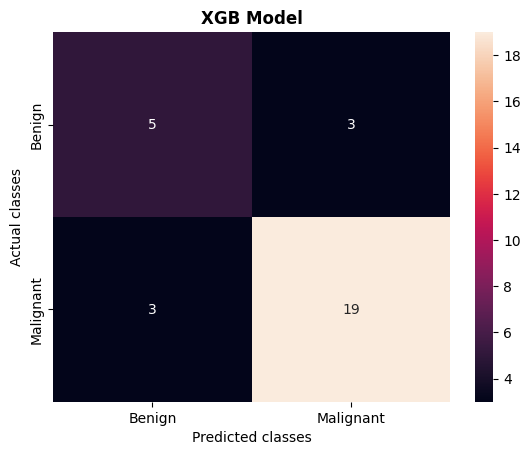

Classification Report
              precision    recall  f1-score   support

           0       0.62      0.62      0.62         8
           1       0.86      0.86      0.86        22

    accuracy                           0.80        30
   macro avg       0.74      0.74      0.74        30
weighted avg       0.80      0.80      0.80        30



In [ ]:
xgb_clf_conf = pd.DataFrame(
    confusion_matrix(y_test, xgb_clf_predict), 
    index=['Benign', 'Malignant'], 
    columns=['Benign', 'Malignant']
)

ax = sns.heatmap(xgb_clf_conf, annot=True) # font size
ax.set(xlabel='Predicted classes', ylabel='Actual classes')

plt.title('XGB Model', weight="bold")
plt.show()
print("Classification Report")
print(classification_report(y_test, xgb_clf_predict))

***Step 14***: Use a ROC curve to find and visualise the balance between sensitivity and specificity of the three models (as illustated below).

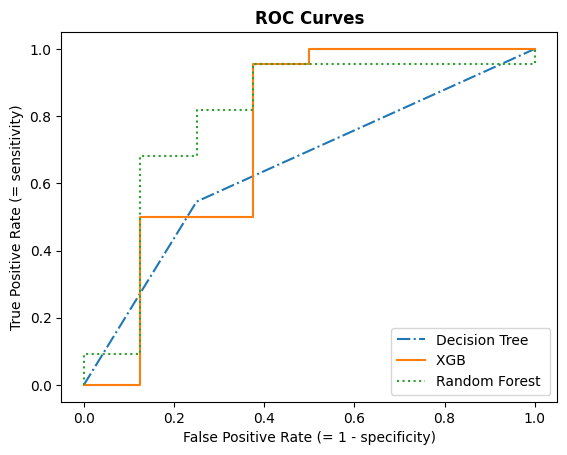

In [ ]:
from sklearn.metrics import auc

probs_dt_clf = dt_clf.predict_proba(X_test)
preds_dt_clf = probs_dt_clf[:,1]
dt_clf_fpr, dt_clf_tpf, _ = roc_curve(y_test, preds_dt_clf)


probs_xgb_clf = xgb_clf.predict_proba(X_test)
preds_xgb_clf = probs_xgb_clf[:,1]
xgb_clf_fpr, xgb_clf_tpf, _ = roc_curve(y_test, preds_xgb_clf)

probs_rf_clf = rf_clf.predict_proba(X_test)
preds_rf_clf = probs_rf_clf[:,1]
rf_clf_fpr, rf_clf_tpf, _ = roc_curve(y_test, preds_rf_clf)

plt.plot(dt_clf_fpr, dt_clf_tpf, linestyle='-.', label = 'Decision Tree ' )
plt.plot(xgb_clf_fpr, xgb_clf_tpf,linestyle='solid',  label = 'XGB ')
plt.plot(rf_clf_fpr, rf_clf_tpf, linestyle=':', label = 'Random Forest ' )

plt.xlabel('False Positive Rate (= 1 - specificity)')
plt.ylabel('True Positive Rate (= sensitivity)')
plt.title('ROC Curves', weight="bold")

plt.legend(loc = 4)
plt.show()